In [1]:
import pandas as pd

df = pd.read_csv("../data/yield_df.csv")   # adjust path if needed
df.head()


,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [2]:
df = df.drop(columns=["Unnamed: 0"])


In [3]:
from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy="median")


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# --------------------------
# Load data
# --------------------------
df = pd.read_csv("../data/yield_df.csv")

# Drop unnecessary index column
df = df.drop(columns=["Unnamed: 0"])

# --------------------------
# Define target and features
# --------------------------
TARGET = "hg/ha_yield"

X = df.drop(columns=[TARGET])
y = df[TARGET]

# --------------------------
# Identify column types
# --------------------------
categorical_features = ["Area", "Item"]
numerical_features = ["Year", "average_rain_fall_mm_per_year", "pesticides_tonnes", "avg_temp"]

# --------------------------
# Preprocessing steps
# --------------------------

# Numerical Pipeline → impute missing values + scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical Pipeline → impute (just in case) + one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine them using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# --------------------------
# Train-test split (80/20)
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)


Training shape: (22593, 6)
Testing shape: (5649, 6)


In [5]:
from sklearn.linear_model import LinearRegression

lr_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

lr_model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [6]:

from sklearn.ensemble import RandomForestRegressor

rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(n_estimators=200, random_state=42))
])

rf_model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [8]:
from xgboost import XGBRegressor

xgb_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", XGBRegressor(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    ))
])

xgb_model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate(model, name):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print(f"--- {name} ---")
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R²:", r2)
    print()

evaluate(lr_model, "Linear Regression")
evaluate(rf_model, "Random Forest")
evaluate(xgb_model, "XGBoost")


--- Linear Regression ---
RMSE: 42144.04496876899
MAE: 29582.507897905605
R²: 0.7551418738725029

--- Random Forest ---
RMSE: 9444.533189905202
MAE: 3463.785252257037
R²: 0.9877028893044111

--- XGBoost ---
RMSE: 13763.631497537268
MAE: 8245.13671875
R²: 0.9738839268684387



In [10]:
import joblib
joblib.dump(xgb_model, "../models/best_model.joblib")


['../models/best_model.joblib']

In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def get_metrics(model, name):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    return {"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2}

results = []
results.append(get_metrics(lr_model, "Linear Regression"))
results.append(get_metrics(rf_model, "Random Forest"))
results.append(get_metrics(xgb_model, "XGBoost"))

metrics_df = pd.DataFrame(results)
metrics_df


,Model,RMSE,MAE,R2
0,Linear Regression,42144.044969,29582.507898,0.755142
1,Random Forest,9444.533190,3463.785252,0.987703
2,XGBoost,13763.631498,8245.136719,0.973884


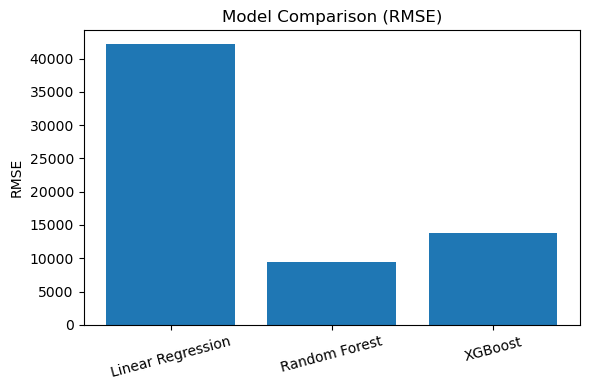

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(metrics_df["Model"], metrics_df["RMSE"])
plt.ylabel("RMSE")
plt.title("Model Comparison (RMSE)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [13]:
import numpy as np

# Get feature names after preprocessing
feature_names = rf_model.named_steps["preprocess"].get_feature_names_out()

# Get importances from the RF inside the pipeline
importances = rf_model.named_steps["model"].feature_importances_

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

fi_top10 = fi_df.head(10)
fi_top10


,feature,importance
108,cat__Item_Potatoes,0.369454
105,cat__Item_Cassava,0.102510
112,cat__Item_Sweet potatoes,0.086242
2,num__pesticides_tonnes,0.070366
46,cat__Area_India,0.058438
1,num__average_rain_fall_mm_per_year,0.043001
3,num__avg_temp,0.042237
0,num__Year,0.032753
114,cat__Item_Yams,0.027481
101,cat__Area_United Kingdom,0.017318


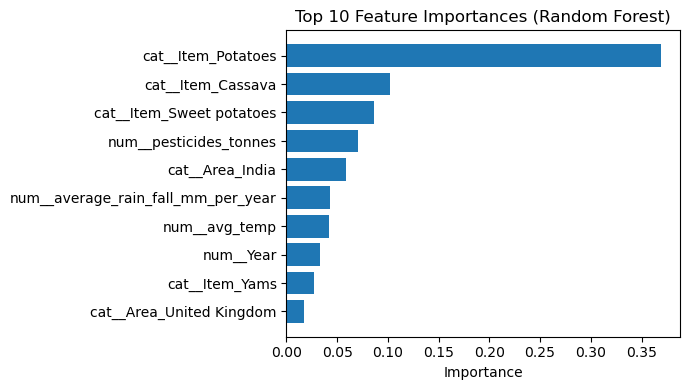

In [14]:
plt.figure(figsize=(7,4))
plt.barh(fi_top10["feature"], fi_top10["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


In [15]:
import joblib

joblib.dump(rf_model, "../models/best_model.joblib")


['../models/best_model.joblib']